# The Solar System 🌌

Picture this: with the flick of a switch, we can unleash the immense power of computers to journey through the vastness of space and unlock the secrets of the universe. Thanks to computational mathematics, we have the tools to peer into distant galaxies, chart the trajectories of celestial bodies, and decipher the language of the stars.

Today, I extend a heartfelt invitation to join me on an extraordinary adventure. Together, we'll traverse the cosmic landscape, exploring the wonders of celestial bodies and unraveling the mysteries of cosmic events. Our destination? A deeper understanding of the universe through the lens of computer simulations.

Imagine a world where we can predict the precise moments when the sun, moon, and Earth align in perfect harmony, casting breathtaking solar and lunar eclipses across the sky. Through meticulous simulations of planetary orbits and gravitational interactions, we can witness the mesmerizing dance of celestial bodies and anticipate the magical moments when they converge.

Our quest is crystal clear: armed with carefully crafted algorithms and mathematical techniques, we aim to embark on a simulation spanning several years. Our mission? To uncover every solar and lunar eclipse set to grace our planet within the prescribed timeframe.

So, are you ready to embark on this exhilarating journey through space and time? Let's harness the power of computational mathematics to unveil the celestial wonders that await us! 🚀🌠

In this chapter, we'll set the stage by covering the main idea of our computational method, while all the relevant background notions, stability analysis, etc... we will cover in the Mathematics Background chapter.

## Understanding the Dynamical System

### The Two-Body Problem

Central to our simulation framework lies a network of initial value problems (IVPs), governed by a core differential equation:

$$
\frac{dx}{dt} = f(t,x), \quad \text{where } t \in [t_0, T]
$$

In this equation, $x$ embodies the state vector, encapsulating both the positions and velocities of celestial bodies at any given time $t$, while $f(t,x)$ represents the vector function that characterizes the dynamics of the system.

This representation stems from the application of Newton’s universal law of gravitation, which dictates that every particle in the universe attracts every other particle with a force that acts along the line joining them. This force is directly proportional to the product of their masses and inversely proportional to the square of the distance between them.

However, the celestial bodies we consider often possess significant mass. To simplify our analysis, we assume each body behaves as if its entire mass were concentrated at a single point known as the center of mass (CM). For two bodies with masses $m$ and $M$, separated by a distance $r$ between their centers of mass, Newton’s universal law of gravitation is expressed as:

$$
F = G\frac{m M}{r^2},
$$

Here, $F$ denotes the magnitude of the gravitational force, and $G$ represents the gravitational constant, with $G = 6.673 \times 10^{-11} N⋅m^2/kg^2$.

Before delving into the intricacies of the solar system, we first explore the elegant simplicity of the two-body problem. This scenario describes the motion of a planet with mass $m$ orbiting a star with mass $M \gg m$, while neglecting the motion of the star. Newton's law of gravity furnishes a system of second-order ordinary differential equations:

$$
m\frac{d^2 x}{dt^2} = mg(x,M), \quad \text{where } g(x,M) = -\frac{GMx}{\|x\|^3} \quad \text{(1)}
$$

In this equation, $x$ signifies the position vector of the planet relative to the star, $G$ stands for the gravitational constant, and $\|x\|$ denotes the magnitude of $x$. Notably, this problem is well-defined only when $\|x\| > 0$.

#### Conversion to First Order ODEs

To facilitate numerical solutions and analysis, we convert the second-order ODEs into a system of first-order ODEs. Let's define a new variable $ v $ as the velocity of the planet:

$$
v = \frac{dx}{dt} \quad \text{(2)}
$$

The system (1) can then be expressed as:

$$
\begin{align*}
\frac{dx}{dt} &= v \\
\frac{dv}{dt} &= -\frac{GMx}{m\|x\|^3}
\end{align*}
$$

These equations represent a coupled system of first-order ODEs that captures the dynamics of the planet's position and velocity in the gravitational field of the star.


Now that we have a clear understanding of the system's physical behavior and have it neatly organized, we can proceed to formulate the initial equations that will serve as the foundation for our program.

In [13]:
#Needed libryries 
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def gravAccF(x, G, M):
    '''
    Gravitational acceleration
    
    Args:
        x (array): position of dynamic body
        G (float): gravitational constant
        M (array): mass of attracting body

    Returns:
        g (array): gravitational acceleration
    
    '''
    g = - ((G*M)/(np.linalg.norm(x,2))**3)*x
    
    return g

In [15]:
def gravAccJac(x, G, M):
    """
    Jacobian of the gravitational acceleration      

    Args:
        x (array): position of dynamic body
        G (float): gravitational constant
        M (array): mass of attracting body

    Returns:
        jacG (array): Jacobian of gravitational acceleration w.r.t. position x
    """
    jacG = (G*M/(np.linalg.norm(x,2))**3)*(-np.identity(3) + 3/(np.linalg.norm(x,2))**2 *np.outer(x,x.T))
    return jacG

Now we can extend the two-body system to a $n$-body system. Here follows the $F$ and the corresponding jacobian:

In [16]:
def nBodyF(t, solVec, mass):
    """
    RHS of the N-body problem
    N-body simulation has been non-dimensionalized

    Args:
        t (float): current time level
        solVec (array): current solution vector (size 1 x 6*N)
        mass (array): array with mass of each body (N x 1)

    Returns:
        f (array): right-hand side of the N-body system (1 x 6*N)
    """
    f = []
    G = 4*np.pi**2           #Gravitational constant
    N = len(mass)             #number of bodies
    for i in range(N):
        sumGraviAcc = np.zeros(3)      # sum gravitational accelerations
        for j in range(N):
            if j != i:
                sumGraviAcc += gravAccF(solVec[(3 + i*6):(i + 1)*6] - solVec[(3 + j*6):(j + 1)*6], G, mass[j])
        
        f1 = np.block([sumGraviAcc,solVec[(0 + i*6):(3 + i*6)]])
        
        if i == 0:
            f = f1
        else:
            f = np.block([f,f1])
    f = np.array(f)
    return f

In [17]:
def nBodyJac(solVec , mass):
    """
    Jacobian matrix of the rhs of the N-body problem
    N-body simulation has been non-dimensionalized

    Args:
        solVec (array): current solution vector (size 1 x (6 * N))
        mass (array): array with mass of each body (1 x N)

    Returns:
        jacF (array): Jacobian matrix of rhs of N-body system (size 6*N x 6*N)
    """
    G = 4*np.pi**2           #Gravitational constant
    N = len(mass)            #number of bodies
    for i in range(N):
        sumJacobians = np.zeros([3, 3])      # sum gravitational accelerations
        for j in range(N):    
            if j != i:
                sumJacobians += gravAccJac(solVec[(3 + i*6):(i + 1)*6] - solVec[(3 + j*6):(j + 1)*6], G, mass[j])
                
        jacFg = np.block([[np.zeros([3, 3]),sumJacobians], [np.identity(3), np.zeros([3, 3])]])
        
        if i == 0:
            jacF = jacFg
            
        else:
            
            loop = False
            j = 0
            while loop == False:
                jacFr1 = np.block([[np.zeros([3, 3]),-gravAccJac(solVec[(3 + j*6):(j + 1)*6] - solVec[(3 + i*6):(i + 1)*6], G, mass[i])], [np.zeros([3, 3]), np.zeros([3, 3])]])
                if i == 1:
                    jacFr = jacFr1
                    loop = True
                else:
                    if j == 0:
                        jacFr = jacFr1
                    else:
                        jacFr = np.block([[jacFr], [jacFr1]])
                    j += 1
                    loop = (j == i)
                    
            loop = False
            p = 0
            while loop == False:
                jacFd1 = np.block([[np.zeros([3, 3]),-gravAccJac(solVec[(3 + i*6):(i + 1)*6] - solVec[(3 + p*6):(p + 1)*6], G, mass[p])], [np.zeros([3, 3]), np.zeros([3, 3])]])
                if i == 1:
                    jacFd = jacFd1
                    loop = True
                else:
                    if p == 0:
                        jacFd = jacFd1
                    else:
                        jacFd = np.block([jacFd,jacFd1])
                    p += 1
                    loop = (p == i)
                    
            jacFr = np.block([[jacFr], [jacFg]])
            jacF = np.block([[jacF], [jacFd]])
            jacF = np.block([jacF, jacFr])
            
    return jacF

### Solving the dynamical system



To solve the IVPs numerically, we employ the β-method, a powerful technique for integrating ordinary differential equations. At each time step, we solve a nonlinear equation of the form:

$$
F(u_{n+1}) = 0, \quad F(x) = x - u_n - hf\left(t_n + \beta, (1-\beta)u_n + \beta x\right)
$$

where $ u_n $ represents the numerical approximation at the $ n $-th step, $ h $ is the step size, and $ \beta $ is a parameter controlling the interpolation between $ u_n $ and $ x $.

But how do we crack this conundrum? Explicitly calculating their zeroes proves nontrivial. Instead, we'll adopt a straightforward yet highly effective technique, commonly employed to approximate function zeroes: **Newton's method**.

Newton's method can be succinctly summarized as follows:


Consider the system $ G(x) = 0 $, where $ G: \mathbb{R}^N \rightarrow \mathbb{R}^N $ encapsulates $ N $ equations and $ N $ unknowns. Assuming $ G $ is differentiable and the [jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of $G(x)$, $ J_G(x) $, is invertible for all $ x $ in $ \mathbb{R}^N $ (or within a suitable subset), we iteratively employ:
$$ x_{k+1} = x_k - [J_G(x_k)]^{-1} G(x_k).$$


In our context, $ G(x) = F(x) $, thus the Jacobians of $ F $ and $ f $, denoted $ J_F(x) $ and $ J_f(x) $ respectively, play a pivotal role. They're defined as:

$$
J_F(x) = I - h\beta J_f((1-\beta)u_n + \beta x)
$$

Now that we have a clear understanding of how to solve numerically the system, thus we can start writing the functions that allows the newton iteration

In [18]:
def fpIterator(phi, x0, tol=1e-8, maxit=20):
    """
    Function that finds the fixed point of a certain function phi, i.e, those points that phi(x) = x

    Possible usages:
        x, success, errEst, xHist = fpIterator_G(phi, x0, tol, maxit) 
        x, success, errEst, xHist = fpIterator_G(phi, x0, tol)
        x, success, errEst, xHist = fpIterator_G(phi, x0)

    Args:
        phi (func): iteration function (function handle) 
        x0 (_type_): initial guess
        tol (float, optional): desired tolerance to stop iterations. Defaults to 1e-8.
        maxit (int, optional): maximum number of iterations. Defaults to 20.

    Returns:
        x (array): solution at the final iteration
        success (boolean): true means converged according to error estimator
        errEst (array): error estimate per iterations 
        xHist (array): solutions per iterations
        
    """
    success = False
    counting = 0      #counting number iterations
    errEst = []
    xHist = [x0]
    loop = False
    while loop == False:
        try:
            x = phi(xHist[counting])
        except ZeroDivisionError:       #check division by zero 
            loop = True                 #stop the iteration
            if counting == 0:
                errEst = x0
                xHist = x0
                x = x0
            else:
                x = xHist[counting]
        else:
            xHist.append(x)
            error = np.linalg.norm(x - xHist[counting])    #error estimate
            errEst.append(error)
            success = (error <= tol)
            counting +=1
            loop = (counting == maxit or success == True )
            
    return x, success, errEst, xHist

In [20]:
def BetaMethod(f, tRange, u0, df, beta, h):
    """
    BetaMethod
    Performs integration for the system of IVPs given by
            d/dt u = f(t, u), u(t_0) = u_0
    using the beta-method

    Args:
        f (array):  the right-hand side function, the output should be a
                    N x 1 array where N is the number of unknowns
        tRange (array): the time interval [t_0, T] of integration
        u0 (N x 1 array): initial solution at t = tRange(1)
        df (func): a function that evaluates the Jacobian matrix of f
        beta (float): defines the method
        h (float): the step-size

    Returns:
        tArray (array): the time points
        solArray (array): containing the solution at each time point
                            (the ith row equals the solution at time tArray(i))
    """
    #Constants
    t_0 = tRange[0]
    T = tRange[1]
    N = len(u0)
    
    #Useful functions
    t = lambda i : t_0 + i*h
    t_beta = lambda i: t(i) + beta*h
    newton = lambda x: x - np.matmul(np.linalg.inv(Jacobian_F(x)),F(x))   #newton formula for system
    F = lambda x:x - solArray[i-1] - h*f(t_beta(i-1), (1-beta)*solArray[i-1] + beta*x)  #F(xstar) = 0
    Jacobian_F = lambda x: np.identity(N) - h*beta*df((1 - beta)*solArray[i-1] + beta*x)
    
    #find the solution
    solArray = [u0]
    tArray = [t_0]
    i = 1
    loop = False
    while loop == False:
        tArray.append(t(i))
        u, success, errEst, xHist = fpIterator(newton, solArray[i-1], tol=1e-12, maxit=50)
        solArray.append(u)
        i += 1
        loop = (t(i) > T or success == False)  #the one with the sucess is for stop the iteration when the convergent is not obtain
        
    solArray = np.array(solArray)
    tArray = np.array(tArray)
    return tArray, solArray

### Simulation of the Solar System

Now we can combine all together and write the function that solve the system

In [21]:
# GIVEN FUNCTION
# simulateSolarSystem

# Simulation of precomputed orbits of celestial bodies
# INPUT
# tArray        1 x Nt array containing the time points
# solArray      (6 N) x Nt array containing the velocities and positions of N bodies
# bodyData      auxilliary data structure

# ------------------------------------------------------------------------------

# define some auxiliary functions
def rangePos(idx):
    idxRange = np.arange((6 * (idx - 1) + 4), 6 * idx +1)
    return idxRange

def nBodyAngularMomentum(solArray, mass):
    N = len(mass)
    solVec = np.reshape(solArray, (N, 6))
    centerOfMass = np.zeros(3)
    for bdx in range(1, N+1):
        centerOfMass += solVec[bdx-1, 3 : 6]*mass[bdx-1]
    centerOfMass = centerOfMass / np.sum(mass)
    angMom = np.zeros((N,3))
    for bdx in range(1,N+1):
        angMom[bdx-1,:] = mass[bdx-1] * np.cross(solVec[bdx-1, 3:6] - centerOfMass, solVec[bdx-1, 0:3])

    return angMom
    
# ------------------------------------------------------------------------------

def simulateSolarSystem(tArray, solArray, mass):
    import matplotlib.pyplot as plt
    N = len(mass)
    angularMomInit = np.sum(nBodyAngularMomentum(solArray[0,:], mass), 0)
    direction3 = angularMomInit / np.linalg.norm(angularMomInit)
    direction1 = np.zeros(len(direction3))
    cdx = np.where(direction3 == np.abs(direction3).min())[0][0]
    direction1[cdx] = 1.
    direction1 = direction1 - np.matmul(direction1, direction3) * direction3
    direction1 = direction1 / np.linalg.norm(direction1)
    direction2 = np.cross(direction3, direction1)

    projPos = []
    for bdx in range(1,N+1):
        A = np.matmul(solArray[:, rangePos(bdx)-1],direction1)
        B = np.matmul(solArray[:, rangePos(bdx)-1],direction2) 
        projPos.append( np.array([[A][0], [B][0]]) )

    cMap =[[       0,    0.4470,    0.7410],
        [  0.8500,    0.3250,    0.0980],
        [  0.9290,    0.6940,    0.1250],
        [  0.4940,    0.1840,    0.5560],
        [  0.4660,    0.6740,    0.1880],
        [  0.3010,    0.7450,    0.9330],
        [  0.6350,    0.0780,    0.1840],
        [  0.7263,    0.3085,    0.3880],
        [  0.8175,    0.5390,    0.5920],
        [  0.9087,    0.7695,    0.7960],
        [  1.0000,    1.0000,    1.0000]]

    fig = plt.figure(figsize=(17,7.5))
    planetname = list(bodyData.keys())

    for bdx in range(N):
        mrk_size = 20*(radius[bdx] / radius[0])**(1/6)
        plt.plot(projPos[bdx][0,:], projPos[bdx][1,:], color=cMap[bdx], label=planetname[bdx]) 
        if beta == 1.:
            plt.plot(projPos[bdx][0,-2], projPos[bdx][1,-2], '.', color=cMap[bdx], markersize=mrk_size)
        else:
            plt.plot(projPos[bdx][0,-1], projPos[bdx][1,-1], '.', color=cMap[bdx], markersize=mrk_size)

    ax = plt.gca()
    ax.set_facecolor('k')
    plt.legend(loc='lower right')
    plt.xlim([-6.,6.])
    plt.ylim([-2.5,2.5])
    plt.title('Orbits after 1 year, $\\beta = %3.1f$' % beta, fontsize=16)
    plt.grid(color = 'white', linestyle = '--', linewidth = 0.5)
    plt.show()

    if beta == 1.0:
        print('--------------------------------------------------------------------------------------------------------------------------')
        plt.figure(figsize=(17,7.5))
        for bdx in range(N):
            mrk_size = 20*(radius[bdx] / radius[0])**(1/6)
            plt.plot(projPos[bdx][0,:], projPos[bdx][1,:], color=cMap[bdx], label=planetname[bdx]) 
            plt.plot(projPos[bdx][0,-2], projPos[bdx][1,-2], '.', color=cMap[bdx], markersize=mrk_size)
        ax = plt.gca()
        ax.set_facecolor('k')
        plt.legend(loc='lower right')
        plt.xlim([-0.25, -0.04])
        plt.ylim([-1.05, -0.95])
        plt.grid(color = 'white', linestyle = '--', linewidth = 0.5)
        plt.title('Earth and Moon orbits after 1 year, $\\beta = %3.1f$' % beta, fontsize=16)
        plt.show()

    print('--------------------------------------------------------------------------------------------------------------------------')

    # Compute and plot angular momentum
    ts = len(tArray) # time steps
    angMomArray = np.zeros( (ts,N) )
    for tdx in range(0,ts):
        value = nBodyAngularMomentum(solArray[tdx, :], mass)
        angMomArray[tdx, :] = np.matmul( direction3, np.transpose(value) )

    angMomArray = np.transpose(angMomArray)
    angMomBdx = [3, 4] # indices of Earth and Moon

    plt.figure(figsize=(17,7.5))
    plt.plot(tArray, angMomArray[angMomBdx[0],:]-angMomArray[angMomBdx[0],0], color=cMap[3])
    plt.plot(tArray, angMomArray[angMomBdx[1],:]-angMomArray[angMomBdx[1],0], color=cMap[4])
    if beta == 1.:
        plt.plot(tArray[-2], angMomArray[angMomBdx[0],-2]-angMomArray[angMomBdx[0],0], '.', color=cMap[3], markersize=mrk_size*2)
        plt.plot(tArray[-2], angMomArray[angMomBdx[1],-2]-angMomArray[angMomBdx[1],0], '.', color=cMap[4], markersize=mrk_size*2)
    else:  
        plt.plot(tArray[-1], angMomArray[angMomBdx[0],-1]-angMomArray[angMomBdx[0],0], '.', color=cMap[3], markersize=mrk_size*2)
        plt.plot(tArray[-1], angMomArray[angMomBdx[1],-1]-angMomArray[angMomBdx[1],0], '.', color=cMap[4], markersize=mrk_size*2)
    plt.title('Increase in angular momentum of Earth and Moon', fontsize=16)
    plt.xlim([0.,tArray[-1]+0.01])
    plt.xlabel('$t$')
    plt.ylabel('$L^b_0(t) - L^b_0(0)$')
    plt.show()

    print('--------------------------------------------------------------------------------------------------------------------------')

    angMom = np.sum(angMomArray, axis=0)
    angMomErr = angMom - angMom[0]
    plt.figure(figsize=(17,7.5))
    plt.plot(tArray, angMomErr, 'k-')
    if beta == 1.:
        plt.plot(tArray[-2], angMomErr[-2], 'ok', markersize=10, markerfacecolor='red')
    else:
        plt.plot(tArray[-1], angMomErr[-1], 'ok', markersize=10, markerfacecolor='red')
    plt.xlim([0.,tArray[-1]+0.01])
    plt.xlabel('$t$')
    plt.ylabel('$\\sum^N_{b=1} (L^b_0(t) - L^b_0(0))$')
    plt.title('Error in total angular momentum', fontsize=16)
    plt.show()


In [22]:
## GIVEN FUNCTIONS
# INPUT
# tStar         increase of time relatively to 'startDate' in years
#
# OUTPUT
# str           string displaying absolute time and date

import datetime as dt

def Time2String(tStar):
    startDate = dt.datetime(2024, 2, 10, 9, 0, 0) # datetime(y, m, d, h, m, s) 
    convDate = startDate.timestamp()

    eclipseTimeInSeconds = (365.25 * 24 * 3600) * tStar

    addToDate = convDate + eclipseTimeInSeconds
    newDate = dt.datetime.fromtimestamp(addToDate)
    
    d = newDate.strftime("%c")

    return(d)

Now we have the integrator, we need the initial conditions, i.e. the position and velocity of a planet at some date. The precise locations and velocities of a planet are obtained from the NASA JPL Horizons online solar system database (https://ssd.jpl.nasa.gov/?horizons). The positions and velocities are those corresponding to May 29-th 2019, at 9am.

In [23]:
## GIVEN DATA
# bodyData >>> dictionary
# planet_name : [[position], [velocity], mass, radius]

import numpy as np

bodyData = {'Sun':     [[-0.001970535866989,0.006992528613755,0.003003353286460],     [-0.003060516548058,9.766503215911289e-05,1.285769889353954e-04], 1.,                    0.004645788049977    ],
            'Mercury': [[-0.103750564753643,0.265872999389654,0.151845741595397],     [-11.786488212332412,-3.043816938682143,-0.404437018499995],      1.660100000000000e-07, 1.631039257833501e-05],
            'Venus':   [[0.690679248097975,0.216272706068898,0.053342373520349],      [-2.191009617045287,6.362618945084622,3.001392241820023],         2.447838300000000e-06, 4.045512126396863e-05],
            'Earth':   [[-0.390407827983219,-0.851914518842311,-0.369327622703087],   [5.699180080971290,-2.233434088853574,-0.968082733568435],        3.003489596320000e-06, 4.263429666582815e-05],
            'Moon':    [[-0.387769495725030,-0.851521423704295,-0.369414334068375],   [5.665513423756666,-2.044803028185879,-0.889439117880211],        3.694303706838754e-08, 1.161781241850256e-05],
            'Mars':    [[-0.737647142329740,1.319523618250907,0.624881276054329],     [-4.369234120273118,-1.747768808918232,-0.683735132118248],       3.227151000000000e-07, 2.270754245434591e-05],
            'Jupiter': [[-1.083725767182327,-4.774617596156765,-2.020193717119794],   [2.664581611056880,-0.373809177417589,-0.225076986037626],        9.547919399999999e-04, 4.778945025452157e-04],
            'Saturn':  [[2.717966807444090,-8.895476170824110,-3.791336560161174],    [1.849168547433158,0.533174622083356,0.140593650870695],          2.858860000000000e-04, 4.028666966848747e-04],
            'Uranus':  [[16.702835279475660,9.904620456544170,4.101720437757826],     [-0.786425398309071,1.042085220791517,0.467526827197142],         4.366243999999999e-05, 1.708513622580592e-04],
            'Neptune': [[29.091455715025140,-6.237643073996448,-3.277367855295219],   [0.261580139664187,1.040386341187902,0.419323757516277],          5.151389000000000e-05, 1.655504846701003e-04],
            'Pluto':   [[12.326835909722869,-28.796445349285797,-12.700526363474438], [1.093172334249140,0.294046564794999,-0.237609365630783],         7.396000000000000e-09, 7.687275190608712e-06]}
# bodyMass >>> mass array
bodyMass = np.array([planet[2] for planet in bodyData.values()])    
radius = np.array([planet[3] for planet in bodyData.values()])
print(bodyMass)

# velAndPos >>> each row contains velocity and position components 
velAndPos = np.zeros((11,6))
planet_data = bodyData.values()
i = 0
for planet in planet_data:
    velAndPos[i, 0] = planet[1][0]
    velAndPos[i, 1] = planet[1][1]
    velAndPos[i, 2] = planet[1][2]
    velAndPos[i, 3] = planet[0][0]
    velAndPos[i, 4] = planet[0][1]
    velAndPos[i, 5] = planet[0][2]
    i += 1

print(velAndPos)

[1.00000000e+00 1.66010000e-07 2.44783830e-06 3.00348960e-06
 3.69430371e-08 3.22715100e-07 9.54791940e-04 2.85886000e-04
 4.36624400e-05 5.15138900e-05 7.39600000e-09]
[[-3.06051655e-03  9.76650322e-05  1.28576989e-04 -1.97053587e-03
   6.99252861e-03  3.00335329e-03]
 [-1.17864882e+01 -3.04381694e+00 -4.04437018e-01 -1.03750565e-01
   2.65872999e-01  1.51845742e-01]
 [-2.19100962e+00  6.36261895e+00  3.00139224e+00  6.90679248e-01
   2.16272706e-01  5.33423735e-02]
 [ 5.69918008e+00 -2.23343409e+00 -9.68082734e-01 -3.90407828e-01
  -8.51914519e-01 -3.69327623e-01]
 [ 5.66551342e+00 -2.04480303e+00 -8.89439118e-01 -3.87769496e-01
  -8.51521424e-01 -3.69414334e-01]
 [-4.36923412e+00 -1.74776881e+00 -6.83735132e-01 -7.37647142e-01
   1.31952362e+00  6.24881276e-01]
 [ 2.66458161e+00 -3.73809177e-01 -2.25076986e-01 -1.08372577e+00
  -4.77461760e+00 -2.02019372e+00]
 [ 1.84916855e+00  5.33174622e-01  1.40593651e-01  2.71796681e+00
  -8.89547617e+00 -3.79133656e+00]
 [-7.86425398e-01  1.04

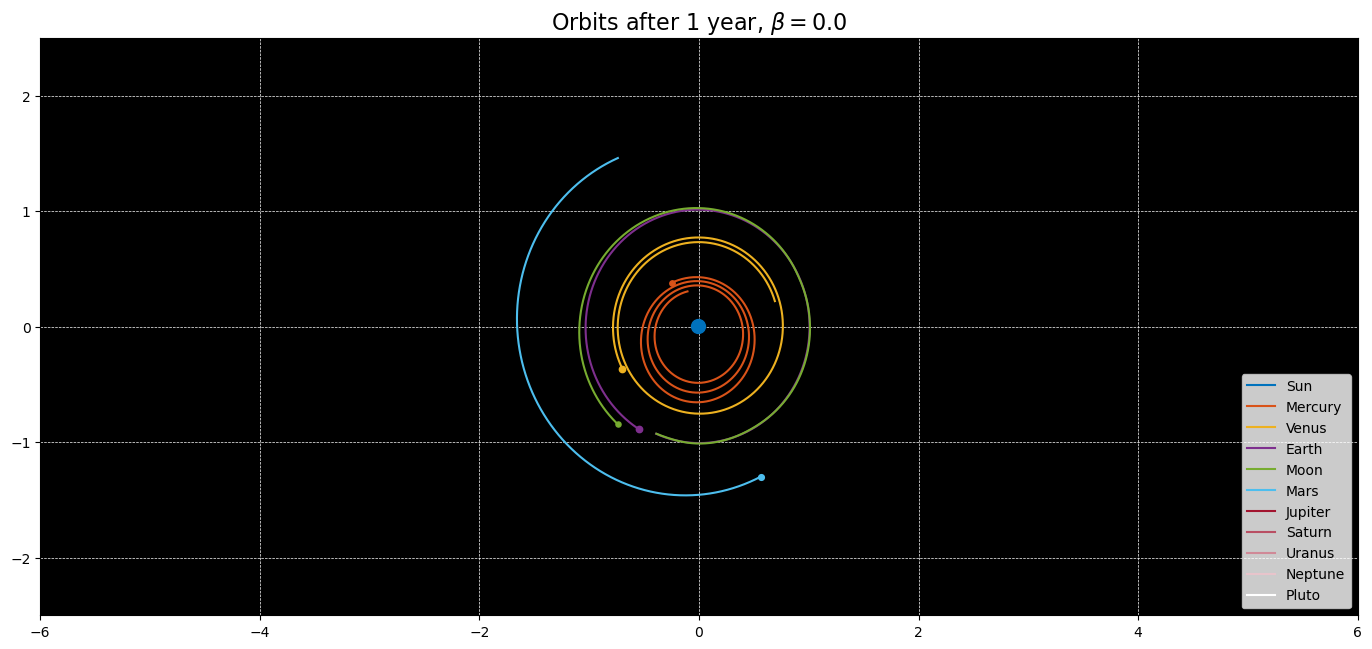

--------------------------------------------------------------------------------------------------------------------------


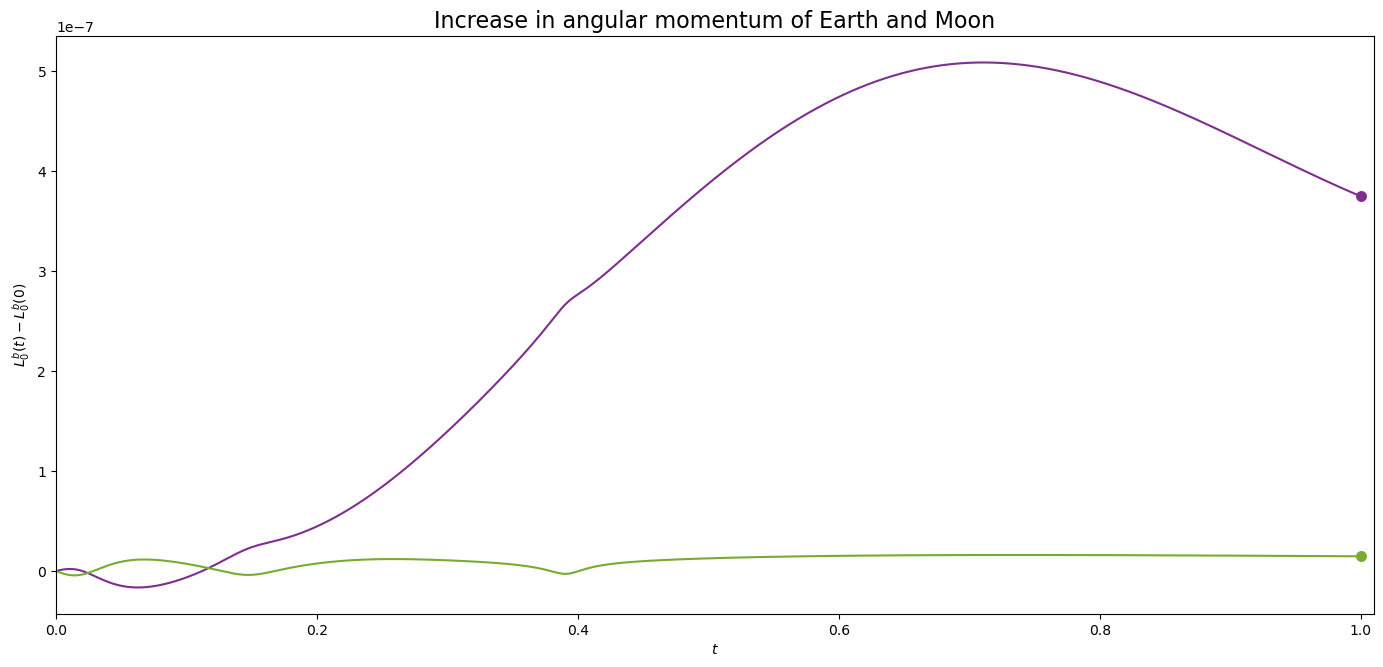

--------------------------------------------------------------------------------------------------------------------------


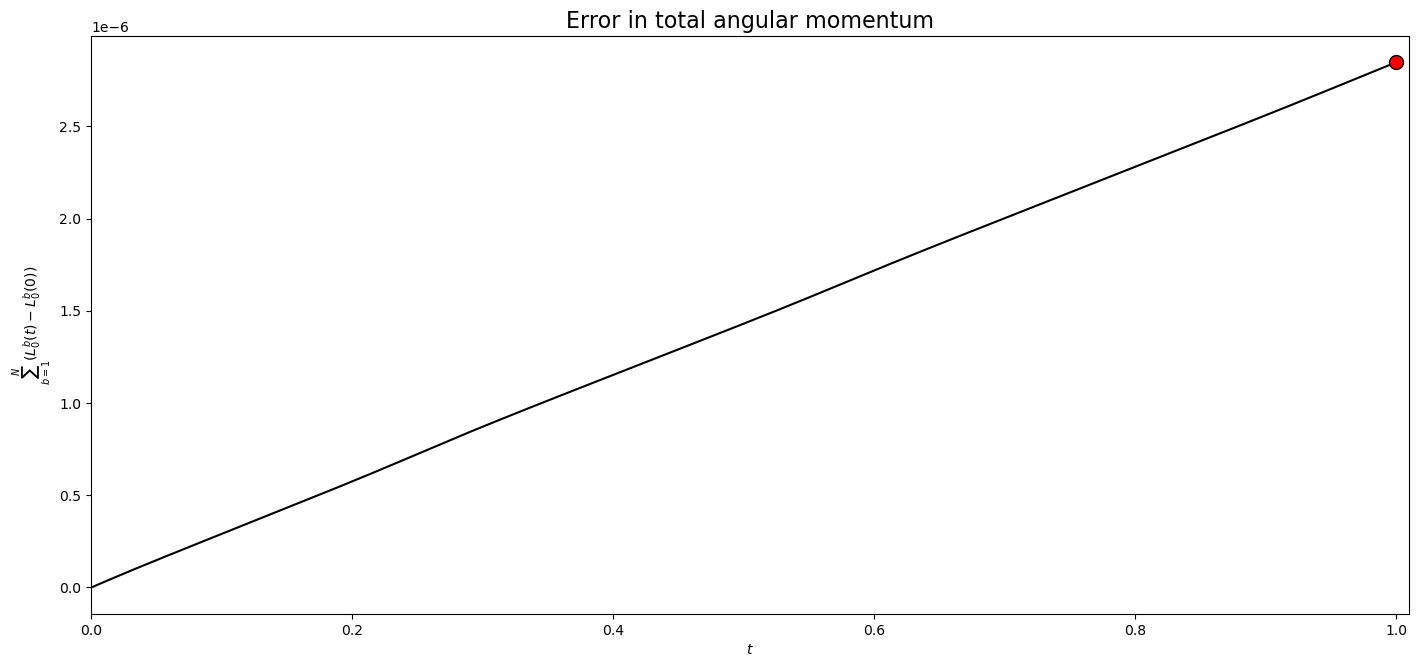

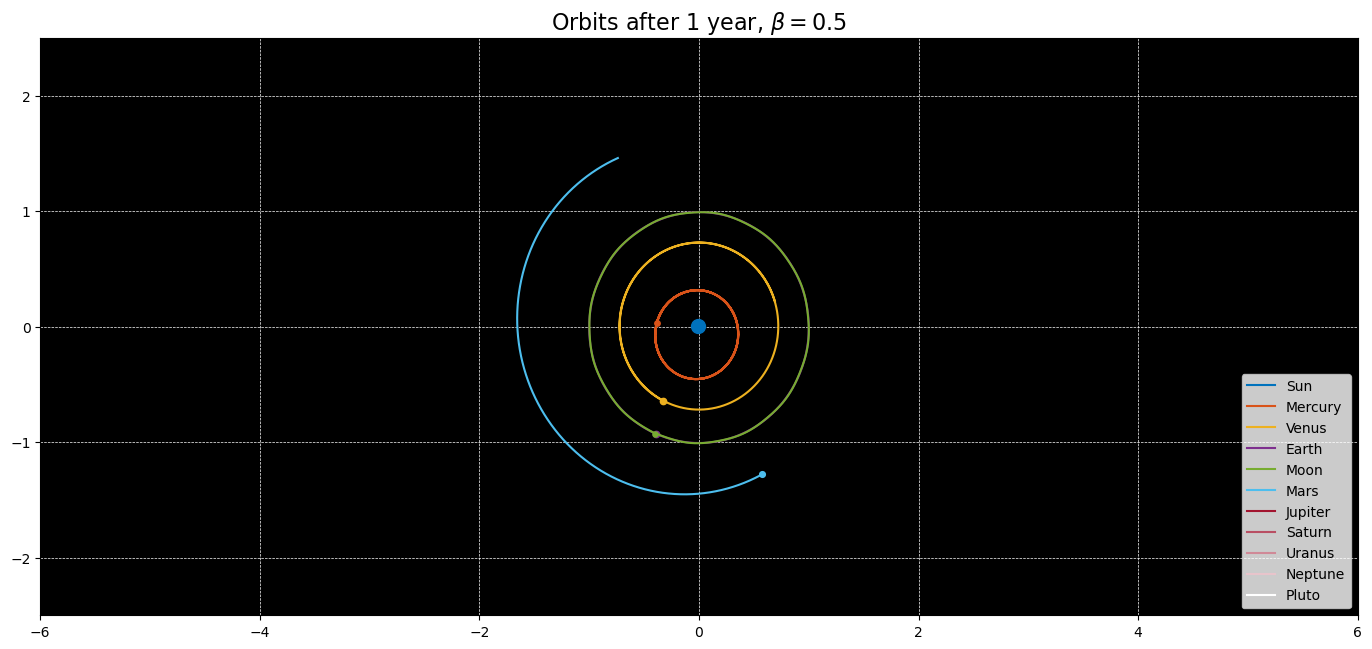

--------------------------------------------------------------------------------------------------------------------------


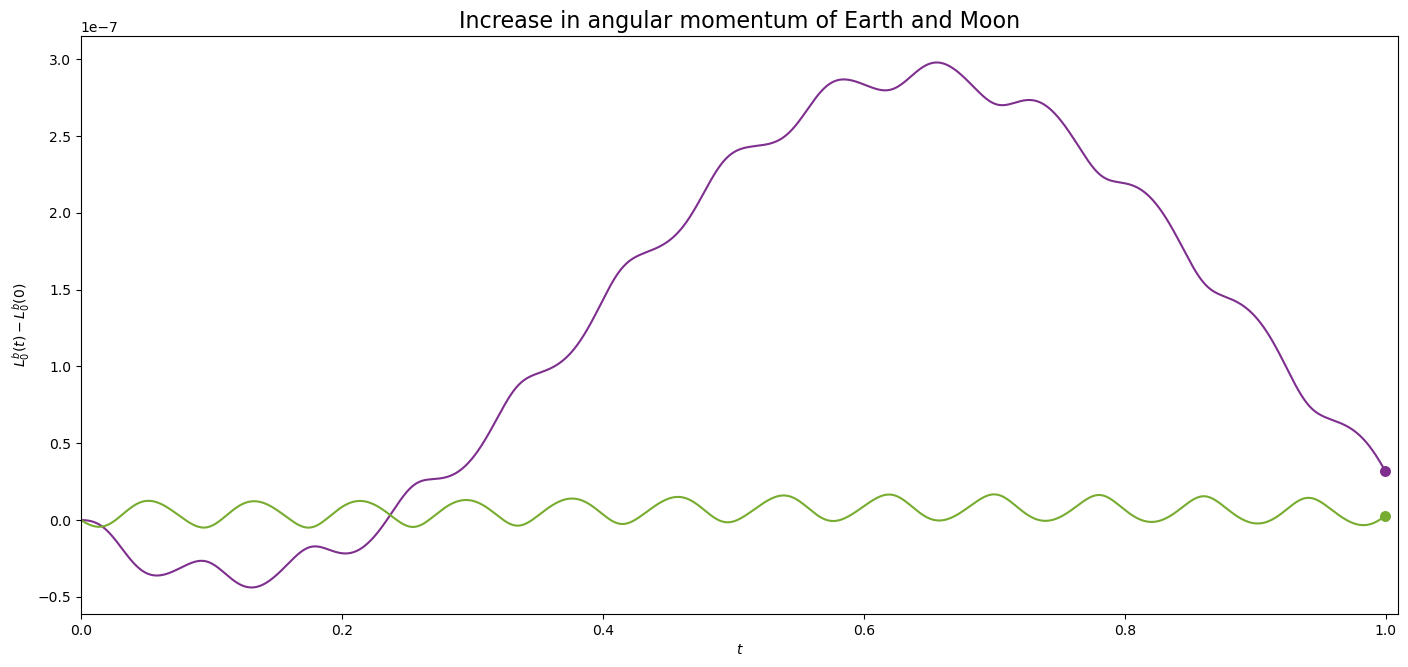

--------------------------------------------------------------------------------------------------------------------------


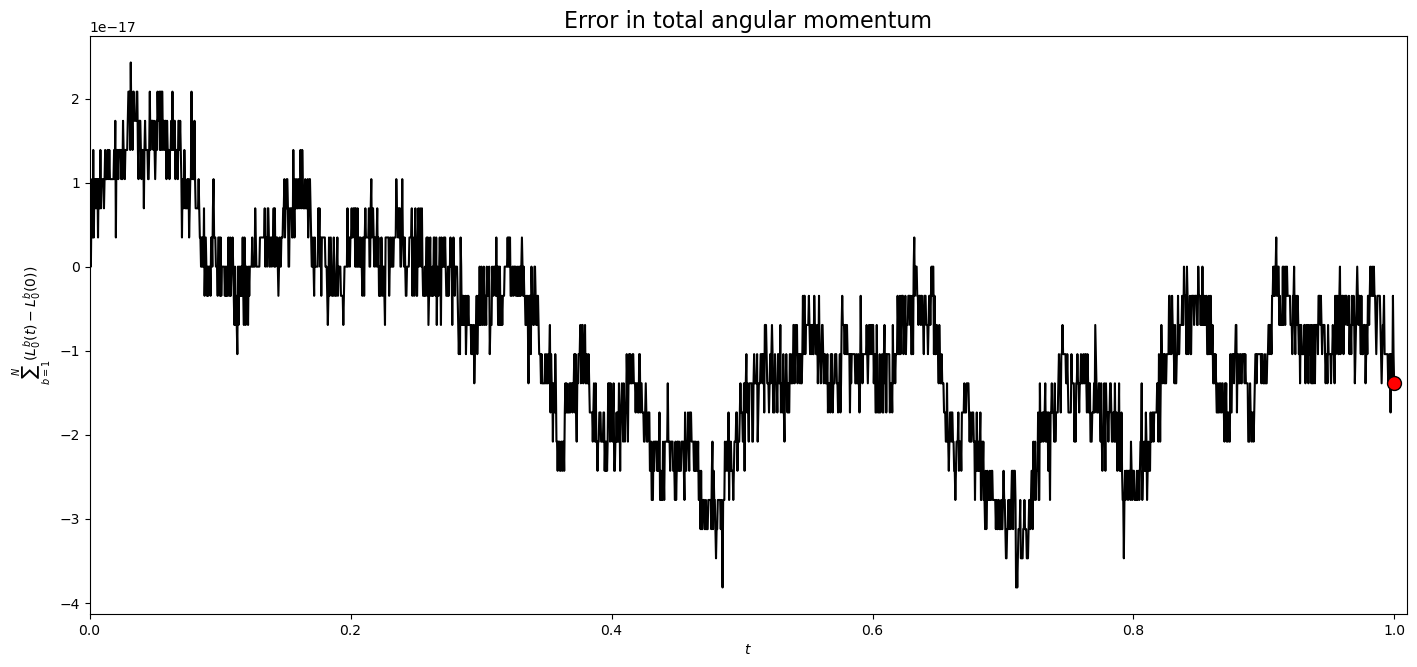

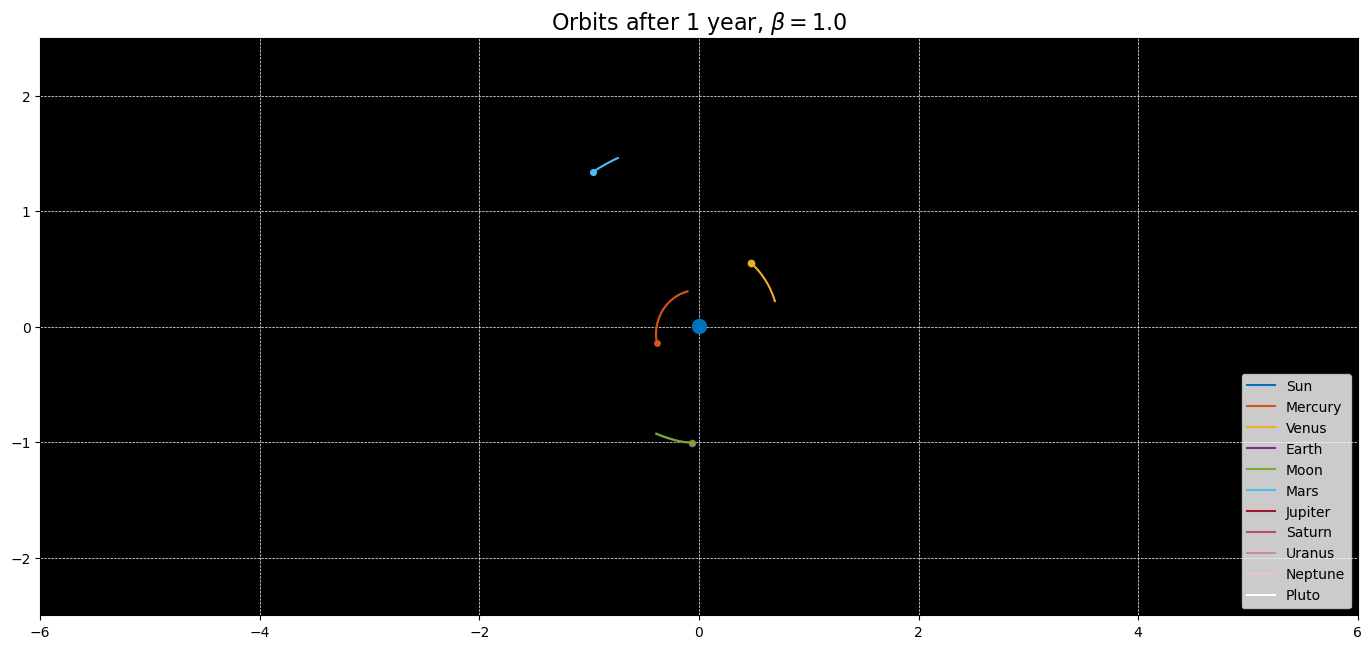

--------------------------------------------------------------------------------------------------------------------------


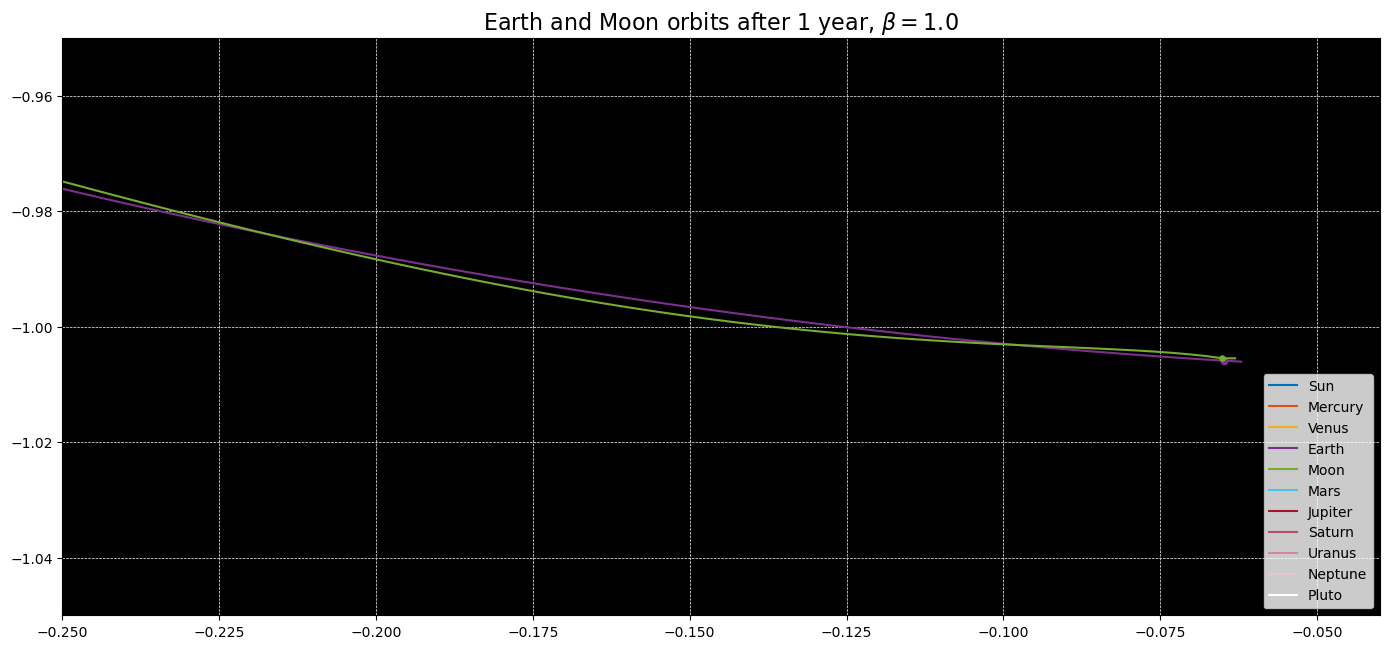

--------------------------------------------------------------------------------------------------------------------------


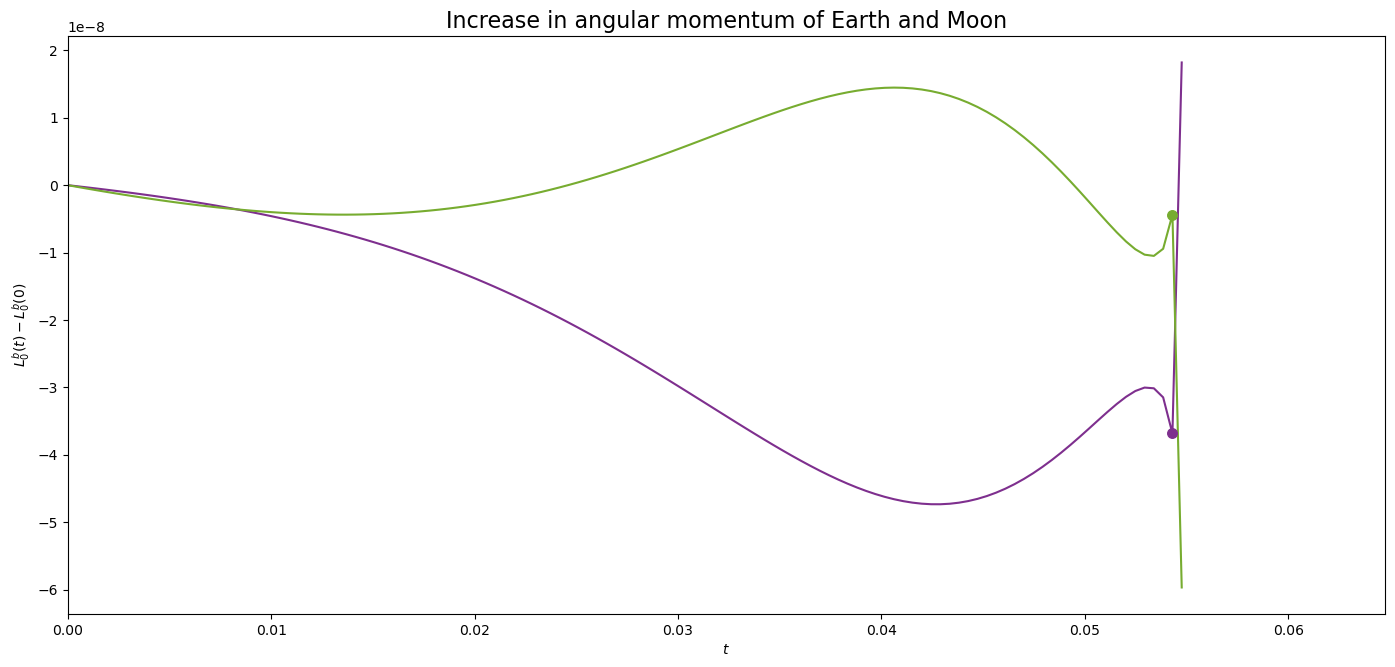

--------------------------------------------------------------------------------------------------------------------------


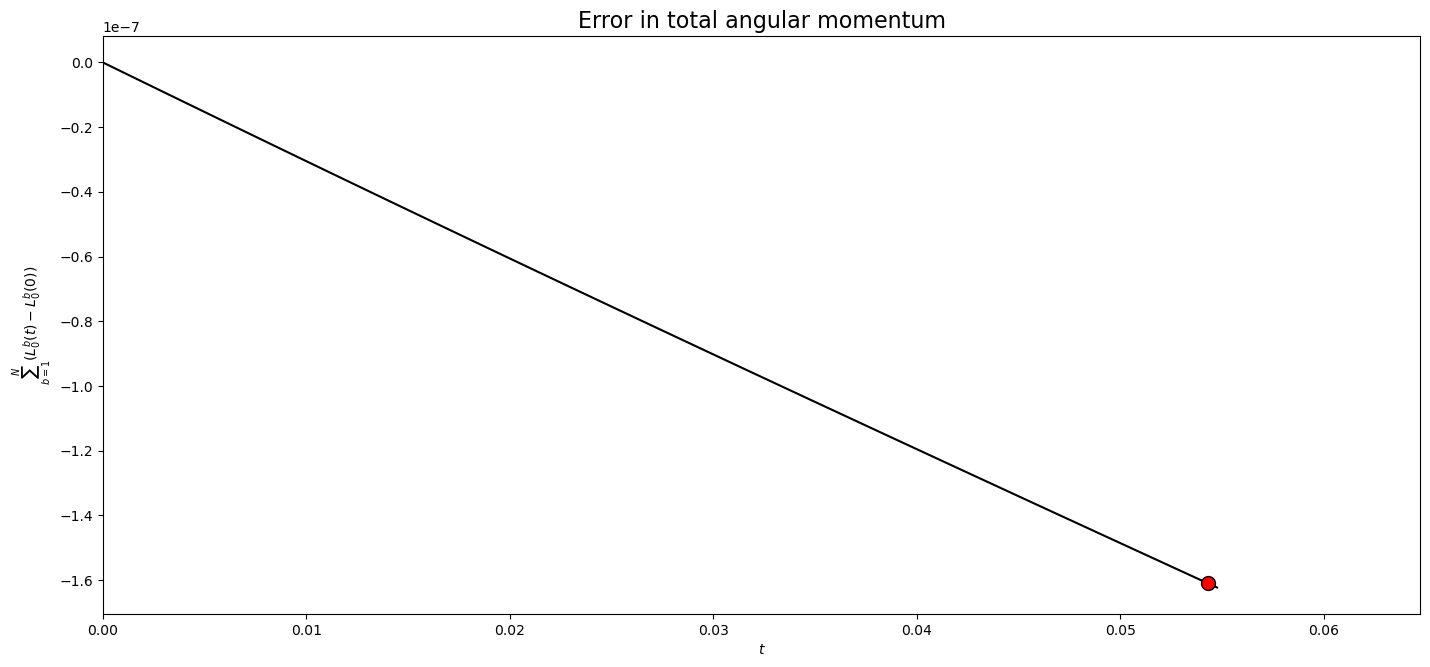

In [24]:
# constants and initial conditions
G = 4*np.pi**2                   #Gravitational constant
R = 1                            #radius
M = 1                            #star mass (sun)
omega = np.sqrt(G*M/R)           #frequency
T0 = 0                           #initial time
T = 1                            #Final time
tRange = [T0, T]                 #time interval
h = (1/365.25)/6                  #time step

# useful functions 
f = lambda t, y: nBodyF(t, y, bodyMass)     
df = lambda y: nBodyJac(y, bodyMass)

#initial values
i = 0
while i < 11:
    if i == 0:
        u0 = velAndPos[i]
    else:
        u0 = np.block([u0,velAndPos[i]])
    i += 1
    

loop = False
beta = 0
while loop == False:
    tArray, solArray = BetaMethod(f, tRange, u0, df, beta, h)
    simulateSolarSystem(tArray, solArray, bodyMass)
    beta += 0.5
    loop = (beta > 1)

In the plots above we have situations of stability and instabilities on our system. 

Let's start with $\beta = 0$. Take a closer look at Earth's orbit. Surprisingly, the Moon, our loyal companion, decides to take a detour. In just one year, it drifts away, breaking the cosmic bond that held it close to our home.

Consider now $\beta = 0.5$

(a) Where does is earth placed after one year?

    The Earth is in the same position it was at the beginning.
    
(b) What happens with the total angular momentum conservation of the whole solar system?

    The total angular momentum changes by very little.

Consider now $\beta = 1$. What happens with the Moon at $t\approx 0.054$?

We can see that angular momentum around that time from increasing suddetly decrease towards reachin its maximum value. At the same time the error is at his maximum and the angular momemtum of the Earth have a symmetric behaviour form decreasing to increase suddenlty and sharply. There is a moment where the angular momentum of the two bodies are equal. This may mean that we have a possible impact. 

The varying behaviors stem from the stability of the Beta-method across different values of beta. For a deeper understanding, refer to the Mathematics Background chapter.

## When is the Next Solar/Lunar eclips?

The upcoming solar and lunar eclips can be found using $\alpha(t)$

$$
\alpha(t) = \frac{\mathbf{d}_{\text{ME}}(t) \cdot \mathbf{d}_{\text{MS}}(t)}{\|\mathbf{d}_{\text{ME}}(t)\|_2 \|\mathbf{d}_{\text{MS}}(t)\|_2}
$$

where $M$ refers to Earth's Moon, $E$ to our Earth, and $S$ to The Sun.

$$
\mathbf{d}_{\text{ME}}(t) = \mathbf{x}_5(t) - \mathbf{x}_4(t), \quad \mathbf{d}_{\text{MS}}(t) = \mathbf{x}_5(t) - \mathbf{x}_1(t).
$$
It can be shown that  $\alpha(t) = 1$ corresponds to a lunar eclipse, while  $\alpha(t) = - 1$ corresponds to a solar eclipse.

In order to separate total from partial eclipses, we will define a solar eclipse as a local minimum of $\alpha(t_n) = \alpha_n$ where additionally $|\alpha_n^* + 1| < 3 \times 10^{-4}$ holds. Similarly, a local maximum of $\alpha_n$ is considered a lunar eclipse if $|\alpha_n^* - 1| < 3 \times 10^{-4}$.



In [26]:
def findLocalMaxima(xVals, yVals):
    """
    Finds nrMax local maxima of y(x)

    Args:
        xVals (Nx1 array): x values array
        yVals (Nx1 array): y values array

    Returns:
        xMax (nrMax x 1 array): the x-values of the local maxima
        yMax (nrMax x 1 array): the local maxima
    """
    N = len(xVals)
    xMax = []
    yMax = []
    for i in range(1,N-1):
        if yVals[i-1]<yVals[i] and yVals[i] > yVals[i+1]:
            x = np.array(xVals[i-1:i+2])
            y = np.array(yVals[i-1:i+2])
            coeffs = np.polyfit(x,y, deg=2)
            xStar = -coeffs[1]/(2*coeffs[0])
            xMax.append(xStar)
            yMax.append(coeffs[0]*xStar**2 + coeffs[1]*xStar+coeffs[2])
    xMax = np.array(xMax)
    yMax = np.array(yMax)
    return xMax, yMax

In [27]:
# constants and initial conditions
G = 4*np.pi**2                   #Gravitational constant
R = 1                            #radius
M = 1                            #star mass (sun)
omega = np.sqrt(G*M/R)           #frequency
T0 = 0                           #initial time
T = 3                            #Final time
tRange = [T0, T]                 #time interval
h = (1/365.25)/12                 #time step
beta = 0.5

# useful functions 
f = lambda t, y: nBodyF(t, y, bodyMass)     
df = lambda y: nBodyJac(y, bodyMass)

alphan = []

#initial values
i = 0
while i < 11:
    if i == 0:
        u0 = velAndPos[i]
    else:
        u0 = np.block([u0,velAndPos[i]])
    i += 1

#Obtaining the time and solution arrays
tArray1, solArray1 = BetaMethod(f, tRange, u0, df, beta, h)

#function for determining alpha (function for find the eclipses)
def alpha(t):
    dME = solArray1[t][(3+4*6):5*6] - solArray1[t][(3+3*6):4*6]
    dMS = solArray1[t][(3+4*6):5*6] - solArray1[t][3:6]
    return np.matmul(dME,dMS)/(np.linalg.norm(dME,2)*np.linalg.norm(dMS,2))

#Calculates values of alpha for each time
i = 0
tAlpha = len(tArray1)

for i in range(tAlpha):
    alphan.append(alpha(i))
    
alphan = np.array(alphan)

solarEclipse = findLocalMaxima(tArray1,-1*alphan)
lunarEclipse = findLocalMaxima(tArray1,alphan)

N0 = len(solarEclipse[0])
N1 = len(lunarEclipse[0])

#Finding the times pof the solar and lunar eclipses
i = 0
for i in range(N0):
    if(abs(-1*solarEclipse[1][i]+1)<3e-4):
        print('Solar eclipse occurs at',Time2String(solarEclipse[0][i]))
        
print('--------------------------------------')

i = 0
for i in range(N1):
    if(abs(lunarEclipse[1][i]-1)<3e-4):
        print('Lunar eclipse occurs at',Time2String(lunarEclipse[0][i]))

Solar eclipse occurs at Fri Mar 15 19:10:49 2024
Solar eclipse occurs at Sun Sep  8 03:38:55 2024
Solar eclipse occurs at Wed Mar  5 03:40:00 2025
Solar eclipse occurs at Thu Aug 28 12:02:02 2025
Solar eclipse occurs at Sun Feb 22 04:36:55 2026
Solar eclipse occurs at Tue Aug 18 00:51:14 2026
Solar eclipse occurs at Tue Jan 12 12:06:34 2027
--------------------------------------
Lunar eclipse occurs at Fri Mar 29 21:06:18 2024
Lunar eclipse occurs at Mon Sep 23 17:31:04 2024
Lunar eclipse occurs at Mon Feb 17 16:37:40 2025
Lunar eclipse occurs at Wed Mar 19 01:24:15 2025
Lunar eclipse occurs at Thu Aug 14 05:14:08 2025
Lunar eclipse occurs at Sat Feb  7 06:01:38 2026
Lunar eclipse occurs at Mon Aug  3 01:34:03 2026
Lunar eclipse occurs at Wed Jan 27 20:14:57 2027


We can compare the results on [here](https://www.timeanddate.com/eclipse/list-solar.html?starty=2020), and we see that, even with our simplify simulation and coarse mesh size, the solution are not that far away from the actual one. 

## Authors and acknowledgment

This Python code was partially provided by C.A. (Cristóbal) Bertoglio, Professor during one of his courses in numerical mathematics at the University of Groningen. We extend our gratitude for his contribution to our understanding of computational mathematics. 